In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import numpy as np
import healpy as hp

## Overdensity

In [3]:
overdensity=np.load("MAPS/density_NS_1024_R_2968_P_2048_DV_80.npy")

In [4]:
import pyccl as ccl

cosmo = ccl.Cosmology(Omega_c = 0.262, Omega_b = 0.048, h = 0.69, sigma8 = 0.83, n_s = 0.96)

z2048=np.load("MAPS/redshifts_NS_1024_R_2968_P_2048_DV_80.npy")
b2048 = 1*np.ones(len(z2048)) #Galaxy bias (constant with scale and z)
ell = np.arange(0, 3072)

numDivs = 80
numSections = 8
dr = numDivs//numSections

cclOut = np.zeros((numSections+1,numSections+1,len(ell)))
simOut = np.zeros((numSections+1,numSections+1,len(ell)))

for start in range(0,numSections):
    for end in range(start+1, numSections+1):
        #print(str(start)+" - "+str(end))
        #ccl power spectrum
        dNdz2048 = np.zeros(z2048.shape)
        dNdz2048[start*dr:end*dr]=1
        clu2048 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z2048,dNdz2048), bias=(z2048,b2048))
        cclOut[start,end] = ccl.angular_cl(cosmo, clu2048, clu2048, ell)
        
        #simulation ps
        rangeOverdensity = np.sum(overdensity[start*dr:end*dr],axis=0)/np.average(np.sum(overdensity[start*dr:end*dr],axis=0))-1
        simOut[start,end] = hp.sphtfunc.anafast(rangeOverdensity)

In [5]:
#calculate the sum squared of the errors
SSE = np.sum(np.power(cclOut[:,:,200:800]-simOut[:,:,200:800],2),axis=2)

In [6]:
fig, ax = plt.subplots(dpi=1200)

im = ax.imshow(np.log(SSE));

labels = np.append(np.array([0.0]),z2048)[::10]

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(np.around(labels,2))
ax.set_yticklabels(np.around(labels,2))

plt.setp(ax.get_xticklabels(), rotation=-45, ha="left",
         rotation_mode="anchor")

plt.xlabel("end Z")
plt.ylabel("start Z")
ax.set_title("Log of SSE for different Z ranges")

fig.colorbar(im)

plt.show();

/tmp/ipykernel_573/3721162464.py:3: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(SSE));


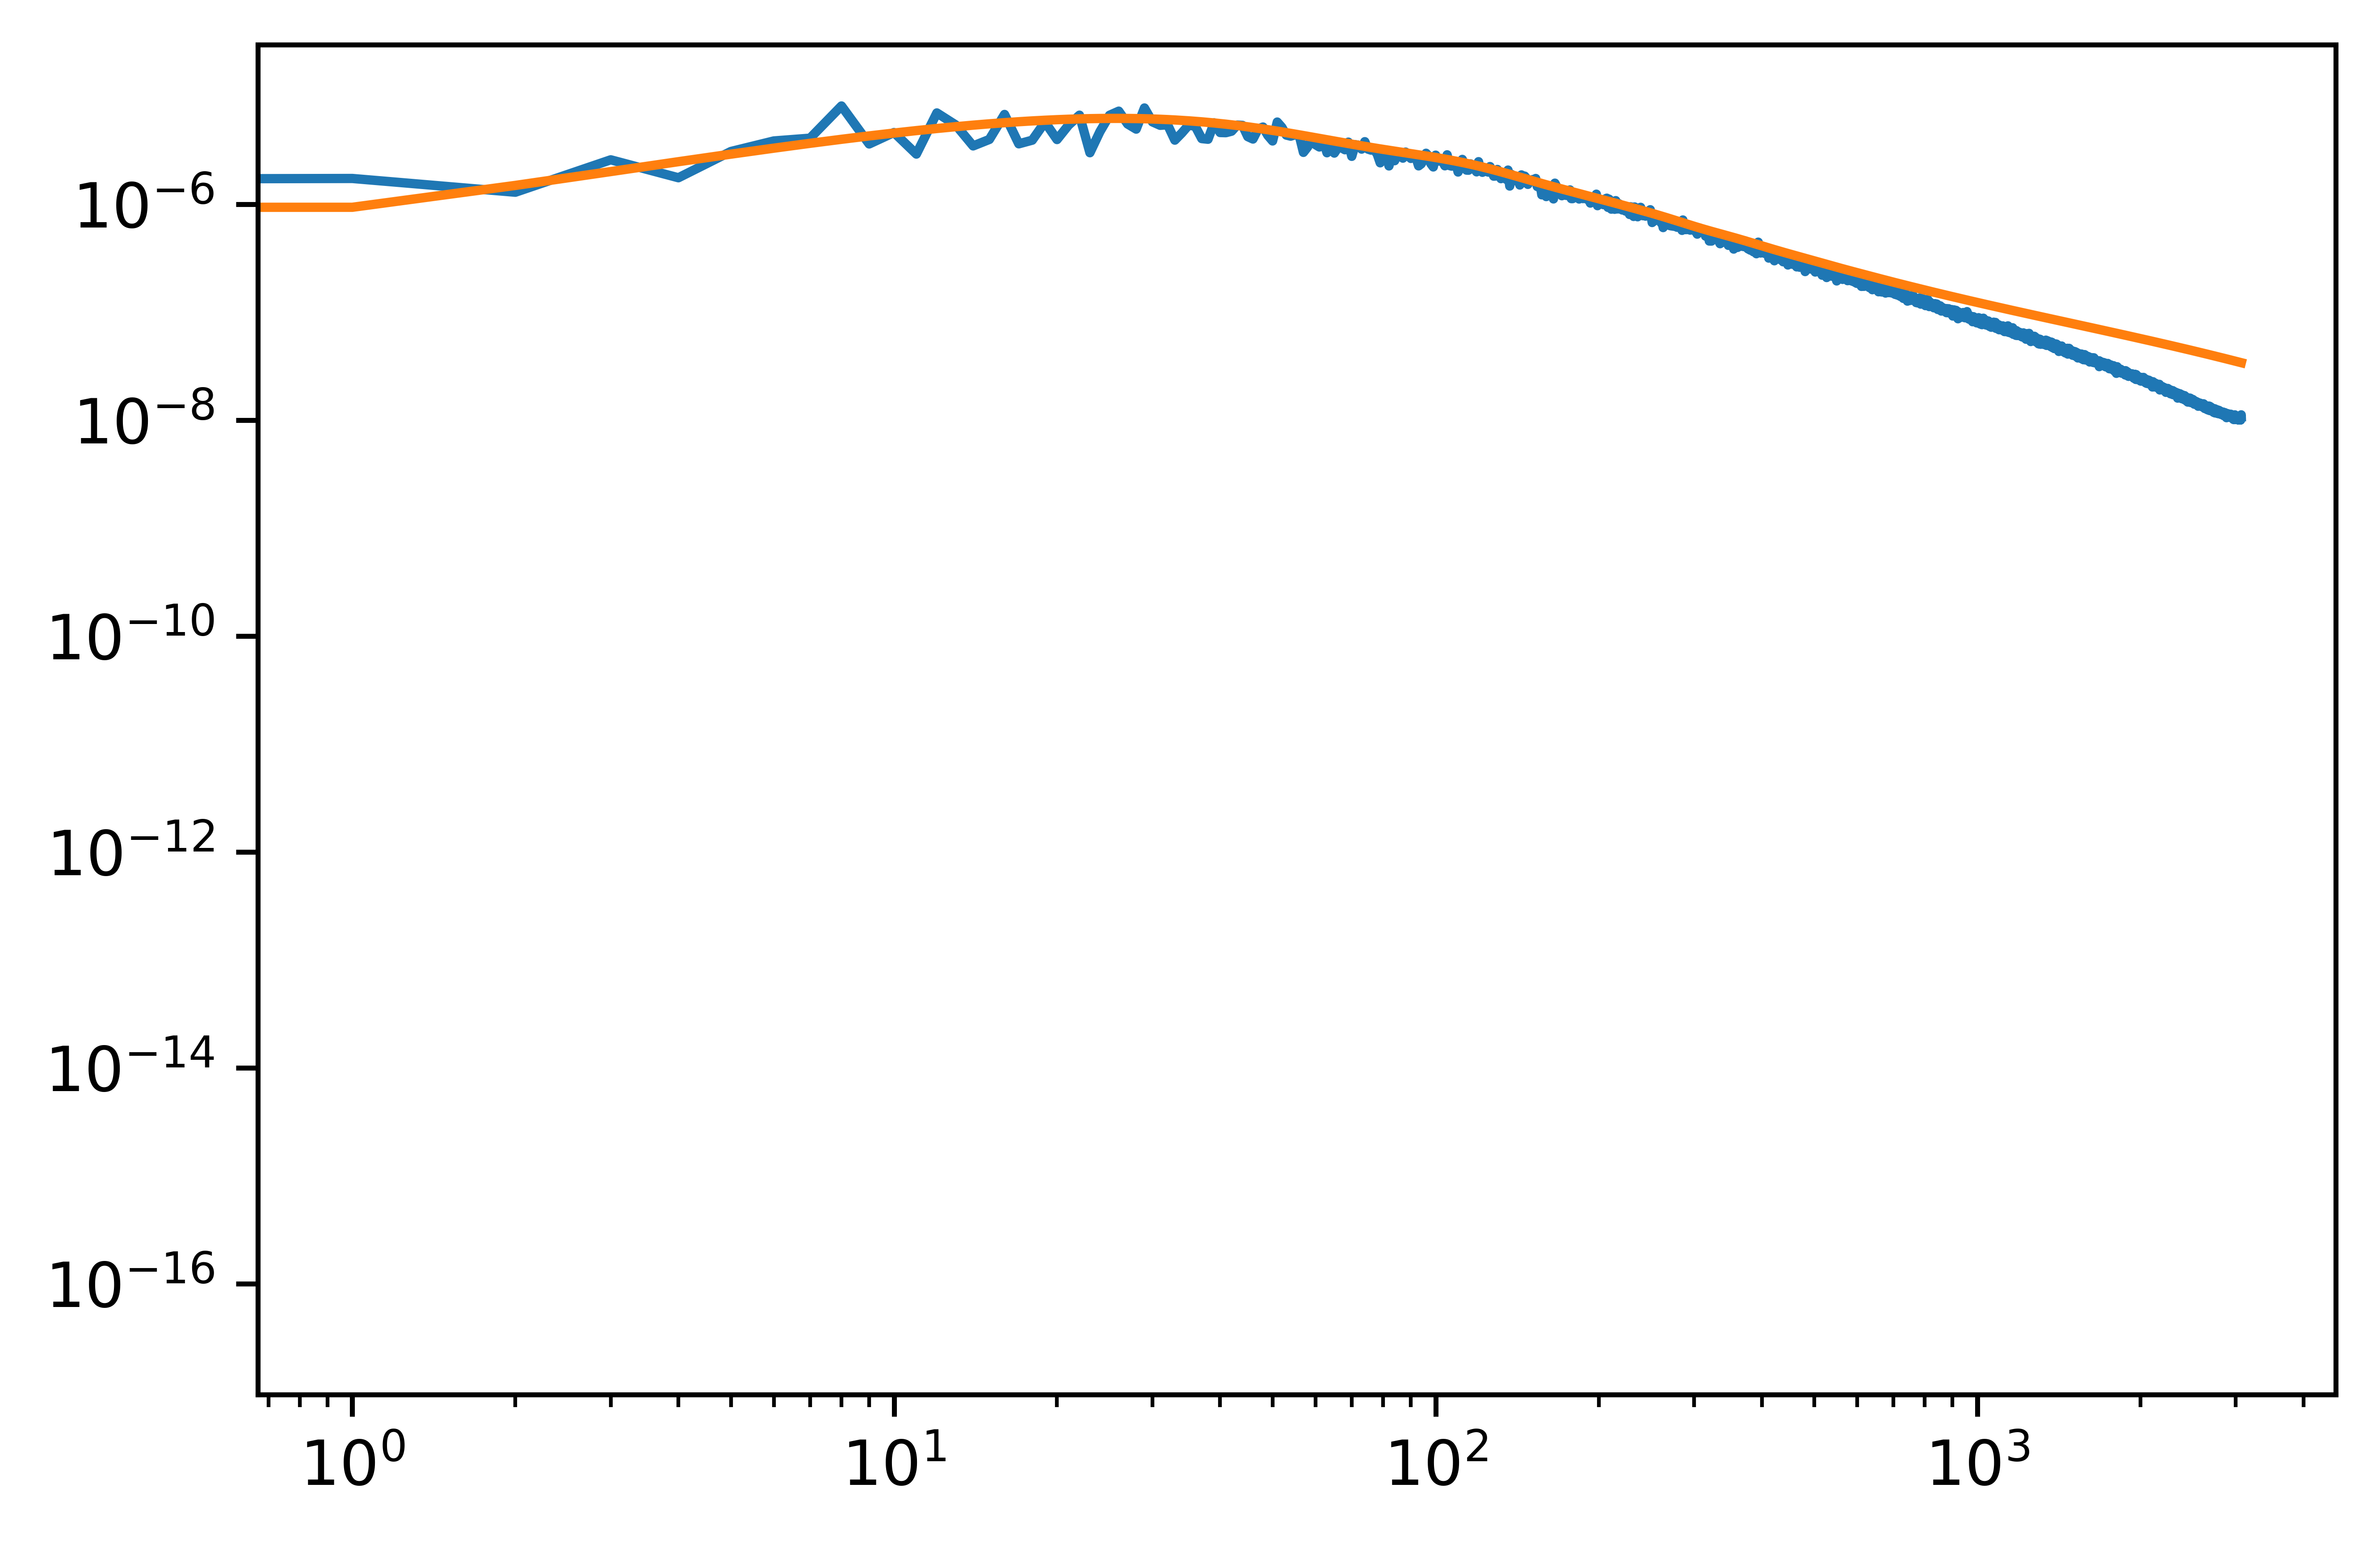

In [7]:
plt.figure(dpi=1000);
plt.loglog(simOut[5,8]);
plt.loglog(cclOut[5,8]);

In [8]:
#calculate the sum squared of the erros with l*(l+1) normalization
SSEls = np.sum(np.power(np.multiply(cclOut,ell*(ell+1))-np.multiply(simOut,ell*(ell+1)),2),axis=2)

/tmp/ipykernel_573/3739516418.py:3: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(SSEls));


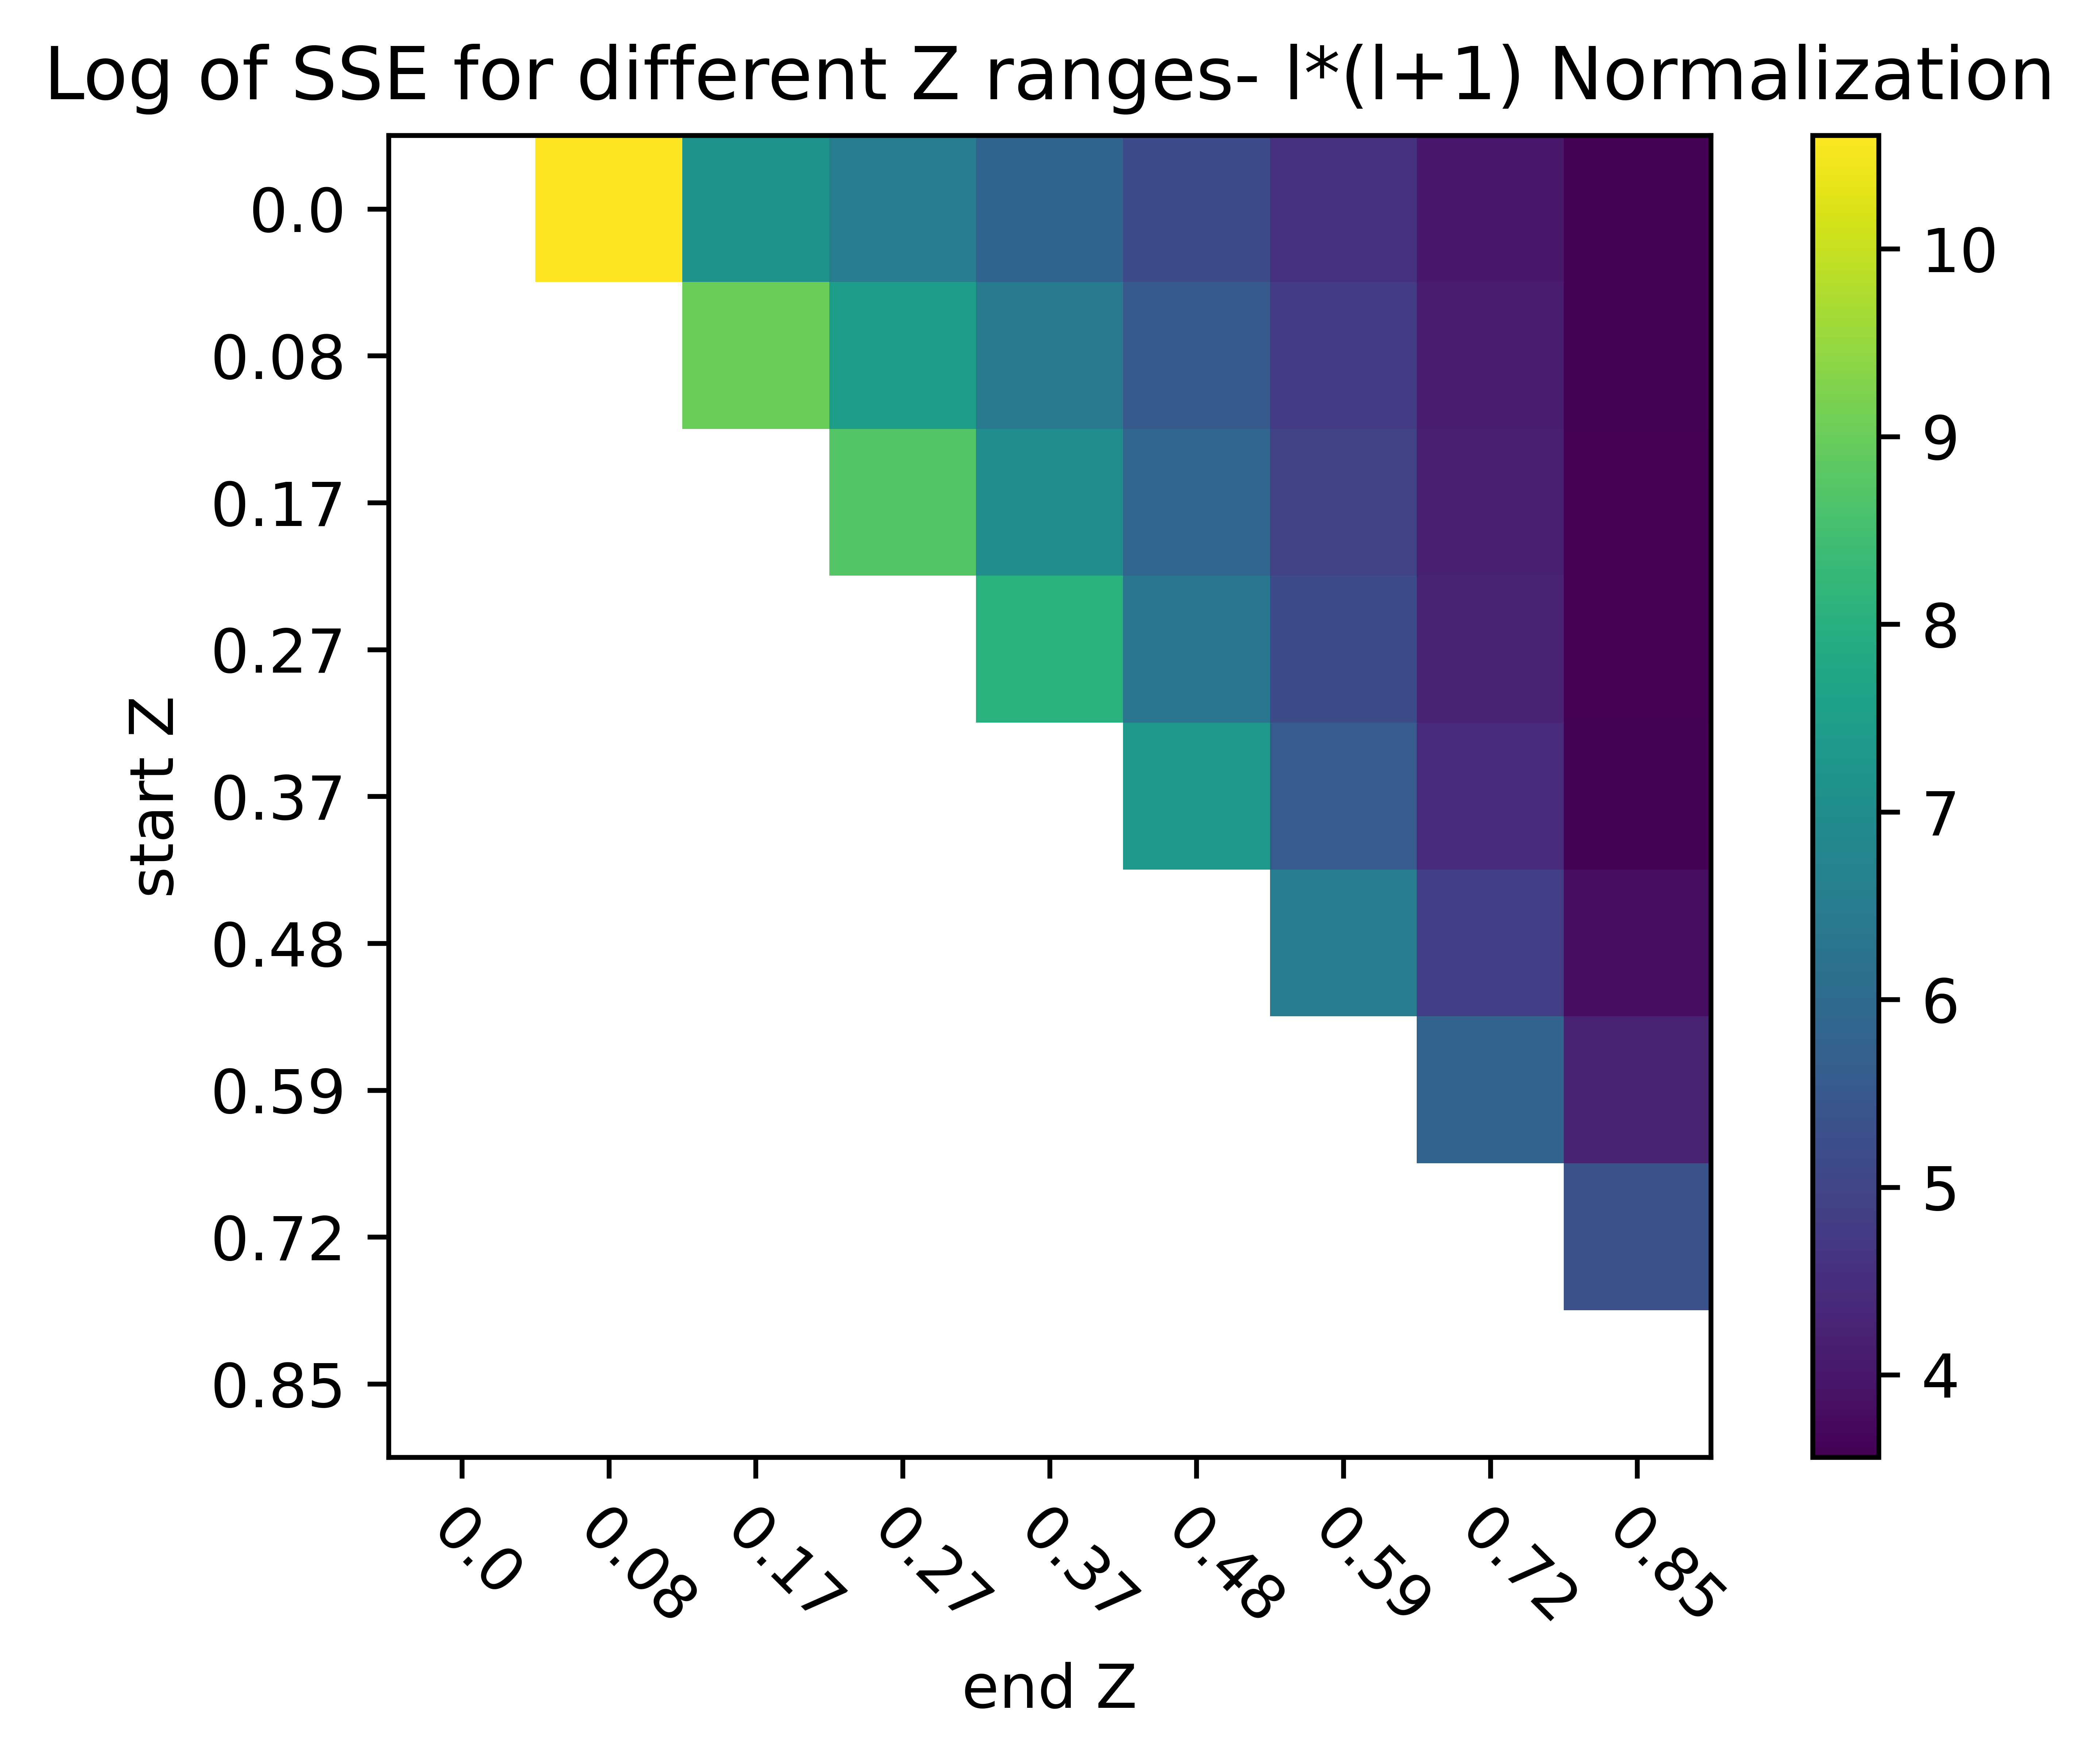

In [9]:
fig, ax = plt.subplots(dpi=1200)

im = ax.imshow(np.log(SSEls));

labels = np.append(np.array([0.0]),z2048)[::10]

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(np.around(labels,2))
ax.set_yticklabels(np.around(labels,2))

plt.setp(ax.get_xticklabels(), rotation=-45, ha="left",
         rotation_mode="anchor")

plt.xlabel("end Z")
plt.ylabel("start Z")
ax.set_title("Log of SSE for different Z ranges- l*(l+1) Normalization")

fig.colorbar(im)

plt.show();

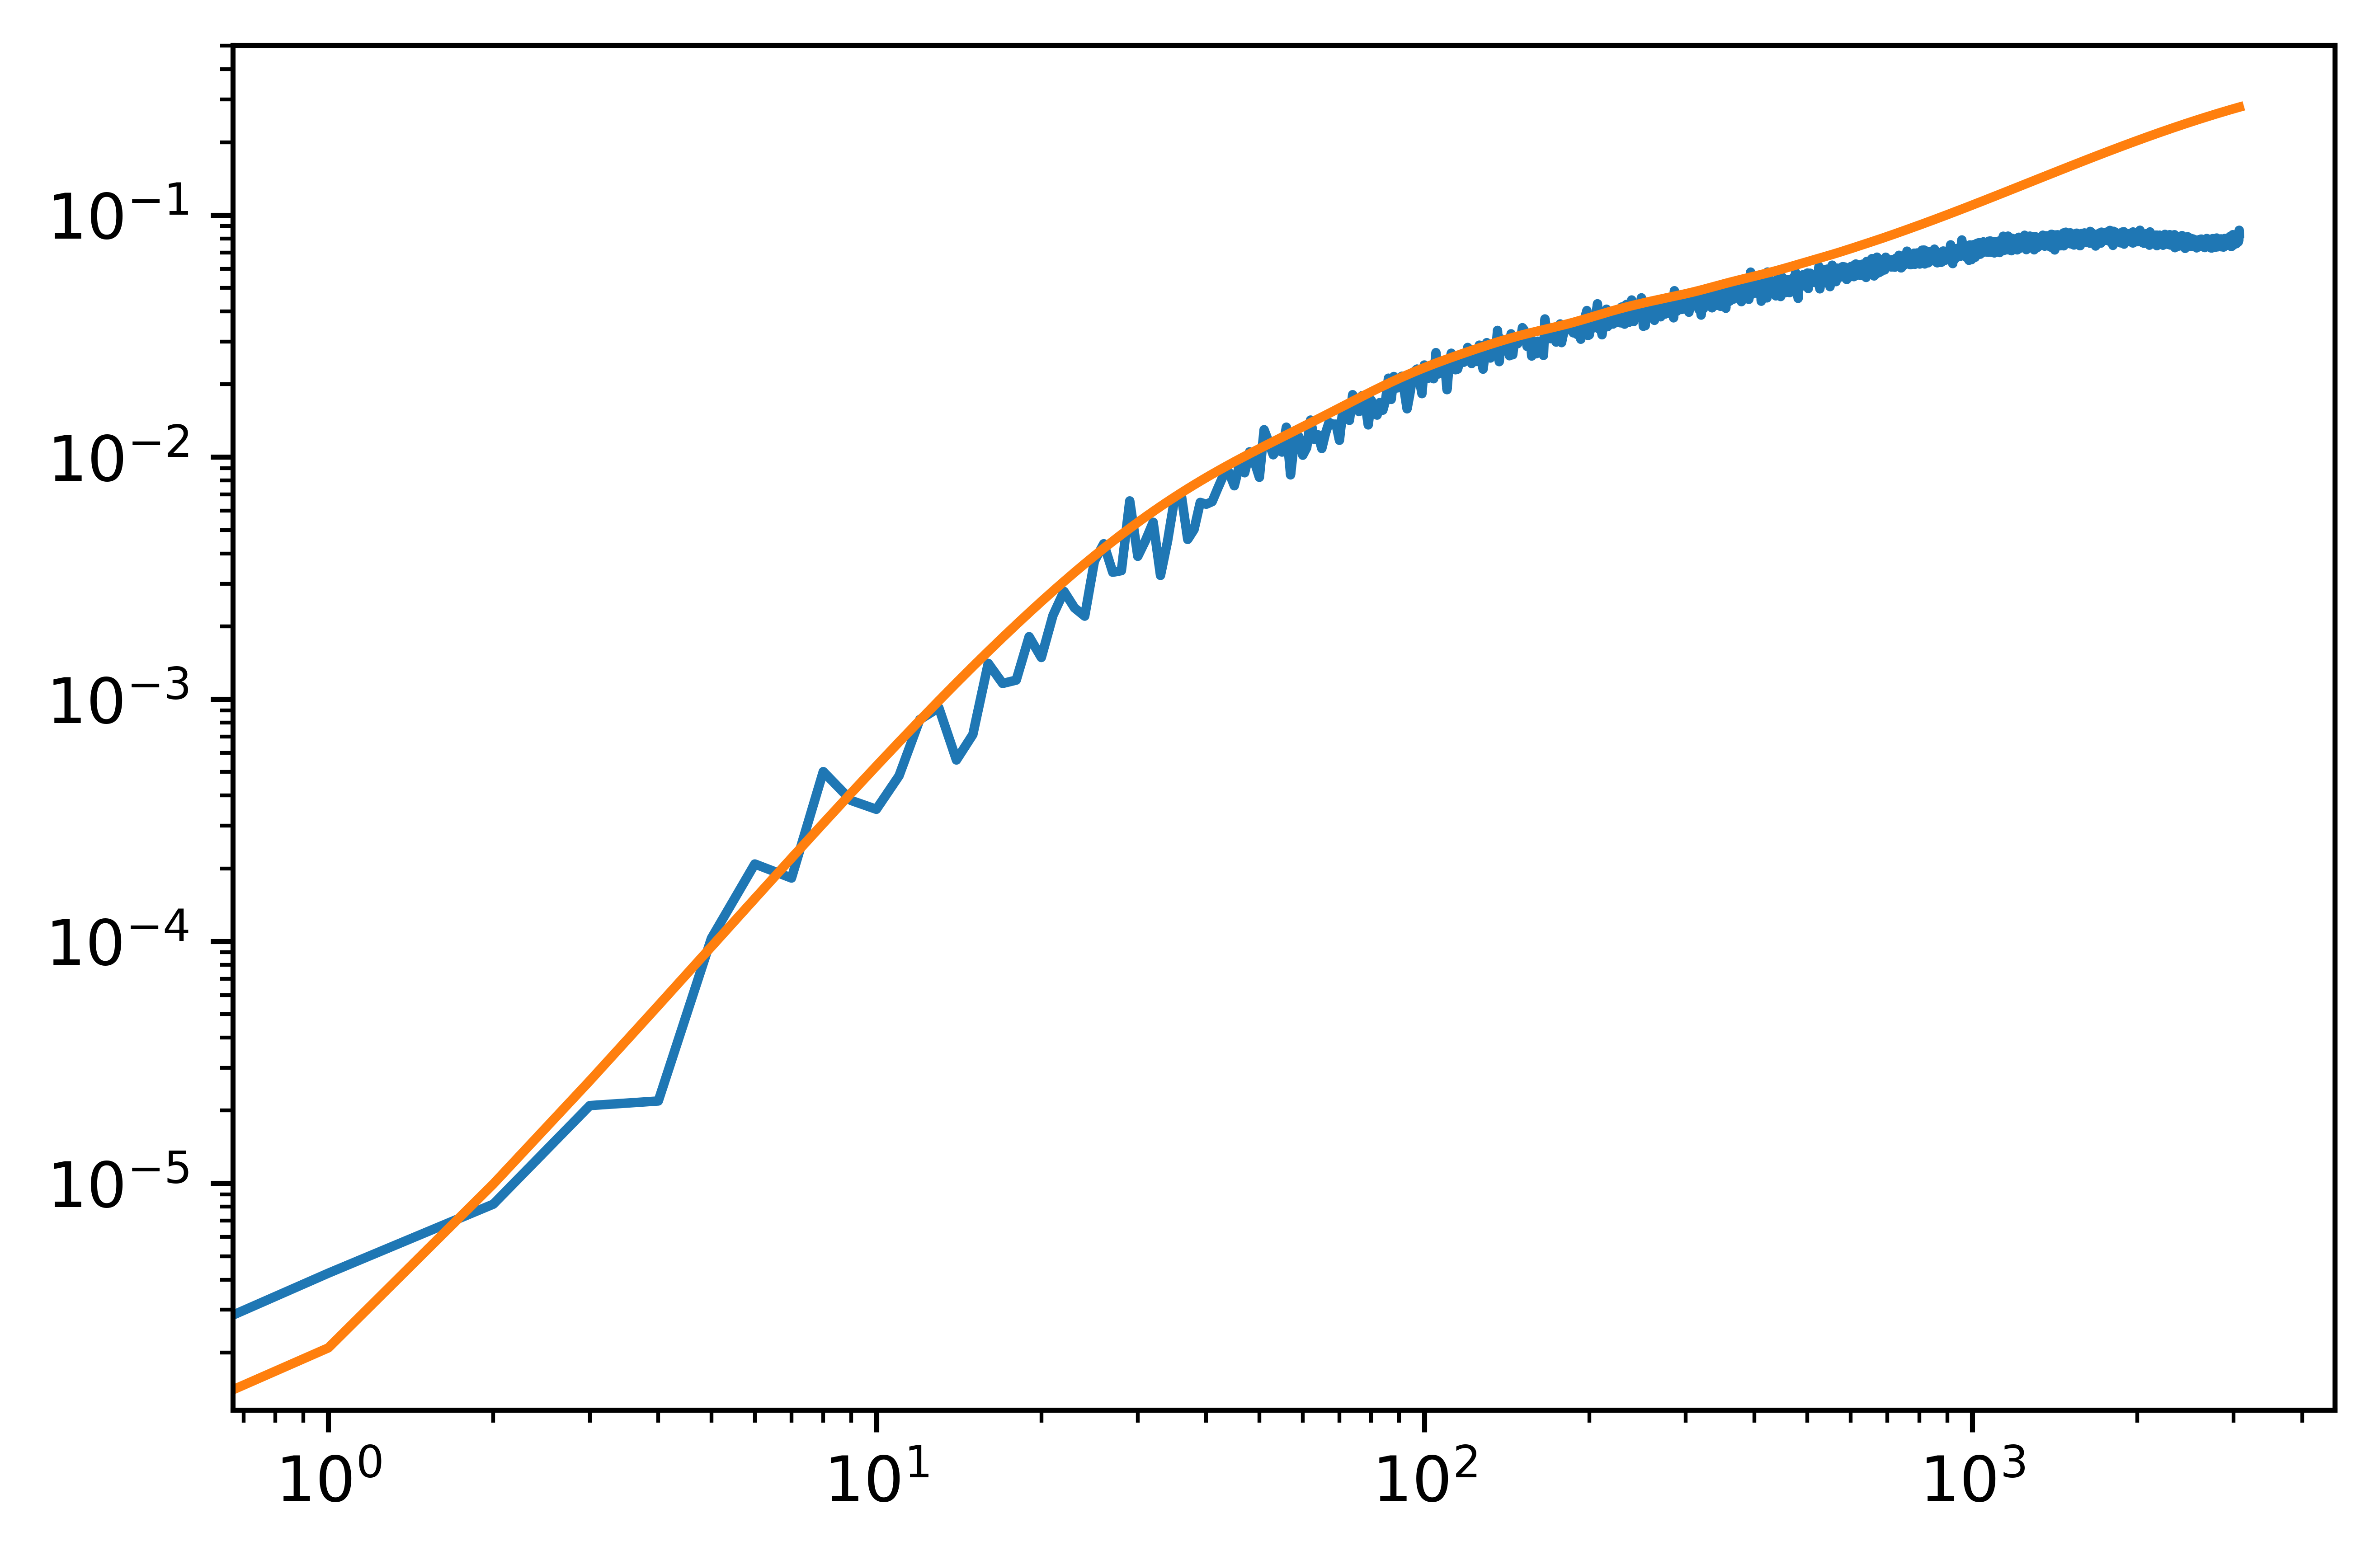

In [10]:
plt.figure(dpi=1000);
plt.loglog(simOut[4,8]*ell*(ell+1));
plt.loglog(cclOut[4,8]*(ell)*(ell+1));

In [11]:
plt.figure(dpi=1200)
for start in range(0,numSections):
    for end in range(start+1, numSections+1):
        plt.loglog(simOut[start,end])
        
plt.ylim(10**-10,10**-2);

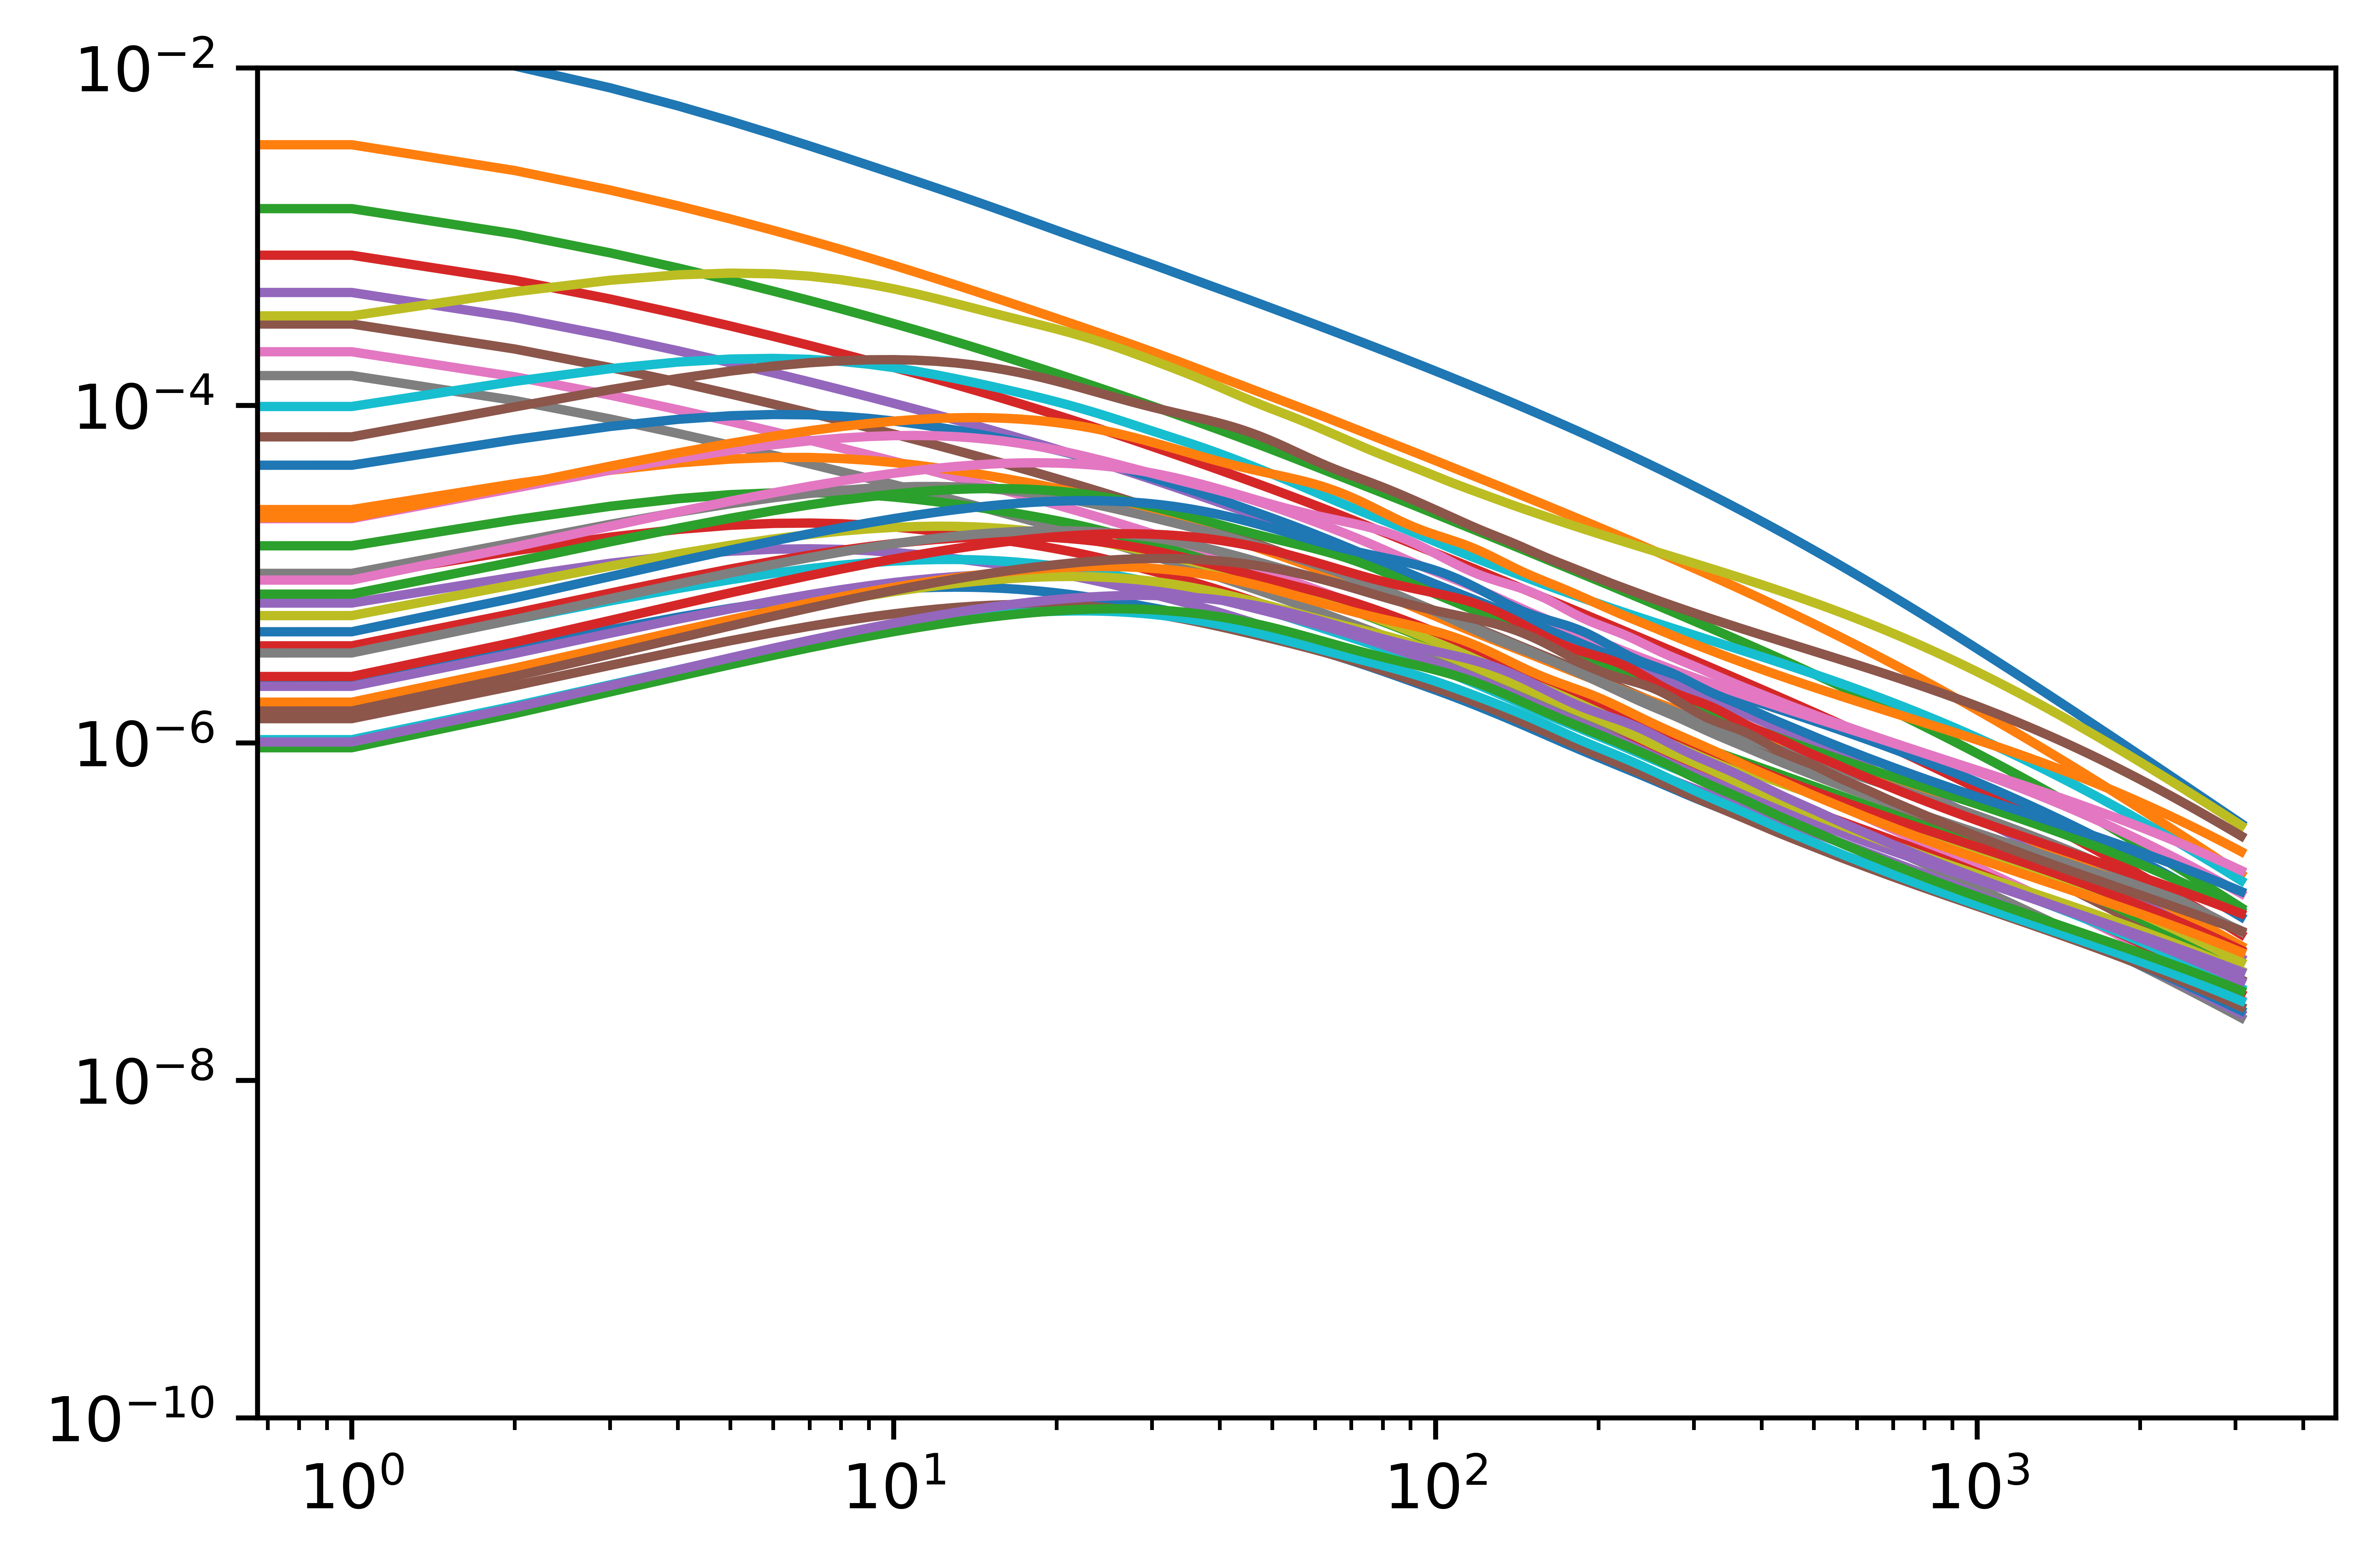

In [12]:
plt.figure(dpi=1200)
for start in range(0,numSections):
    for end in range(start+1, numSections+1):
        plt.loglog(cclOut[start,end])
        
plt.ylim(10**-10,10**-2);

/tmp/ipykernel_573/1863505707.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=100)


<Figure size 7200x4800 with 0 Axes>

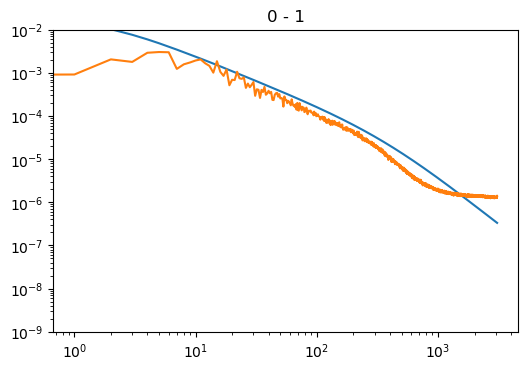

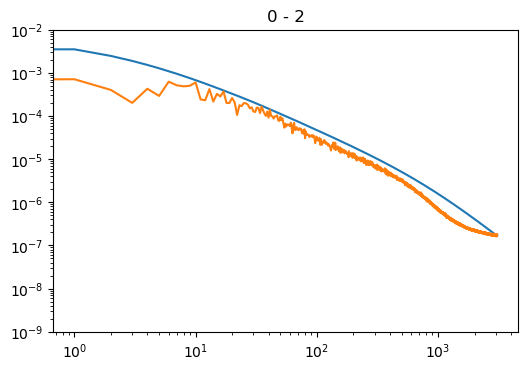

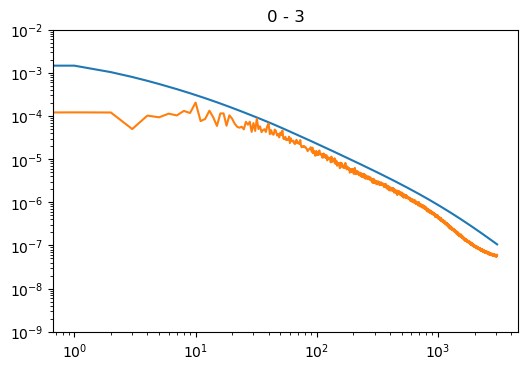

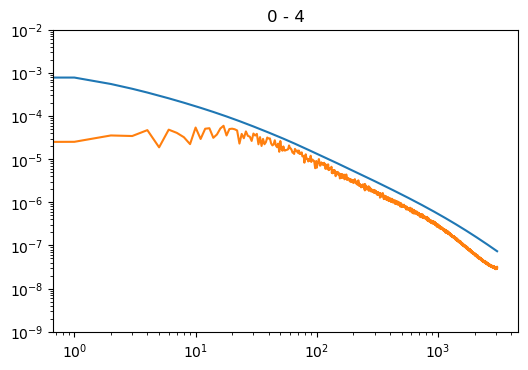

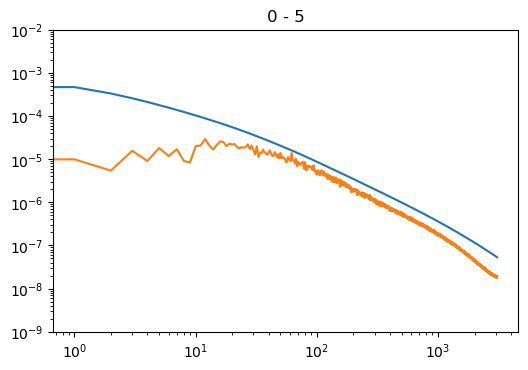

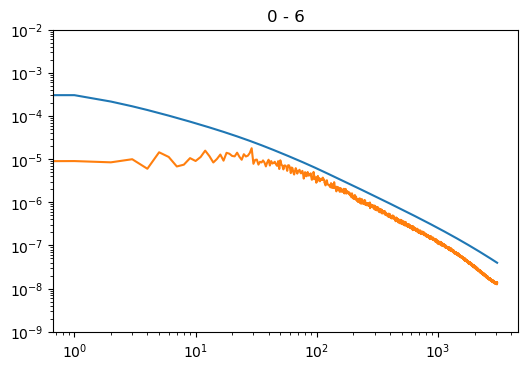

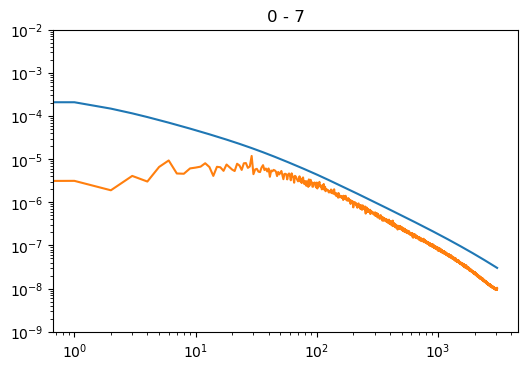

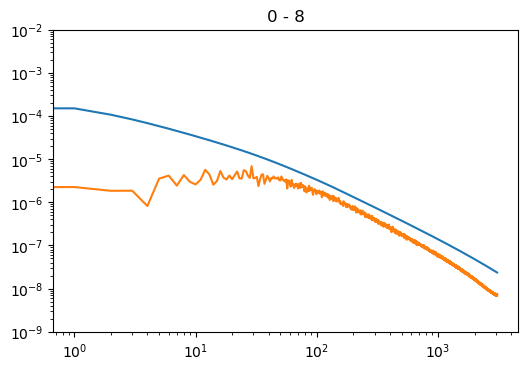

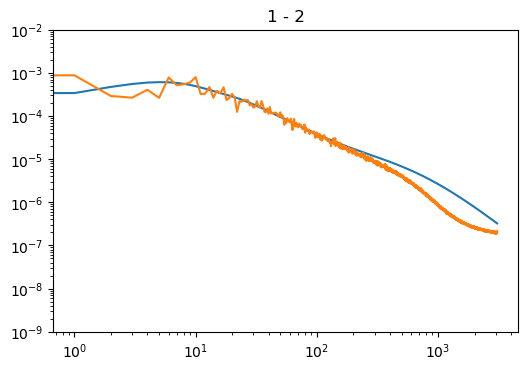

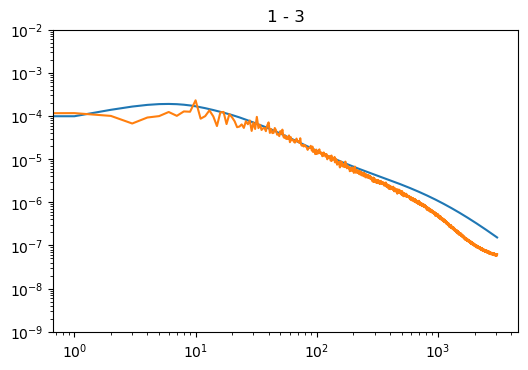

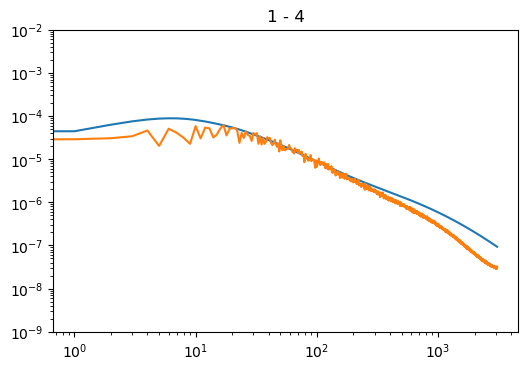

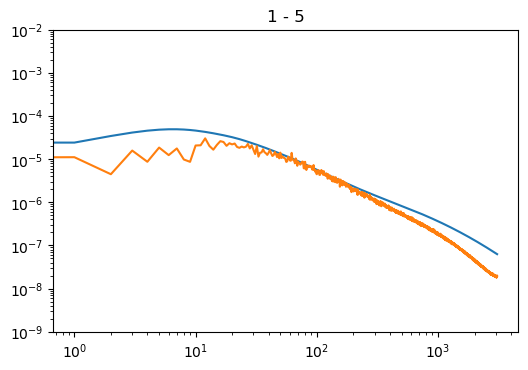

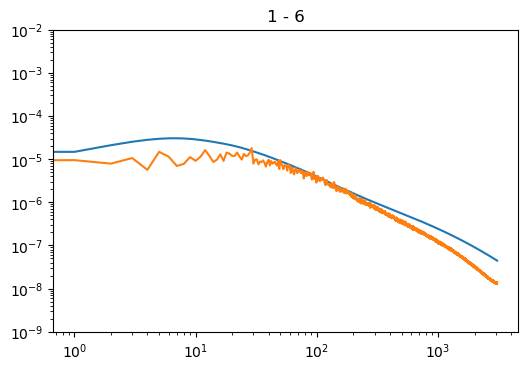

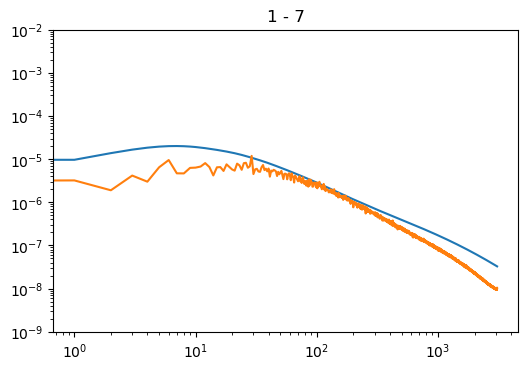

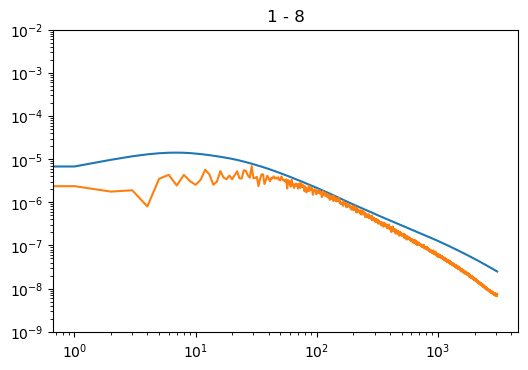

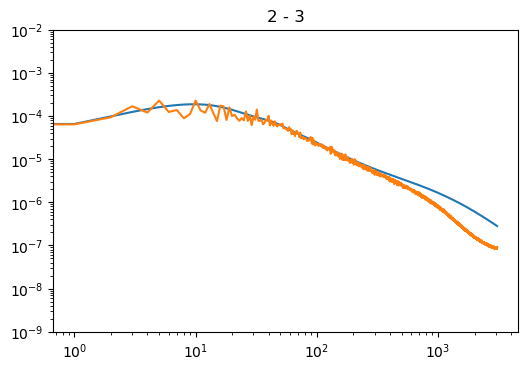

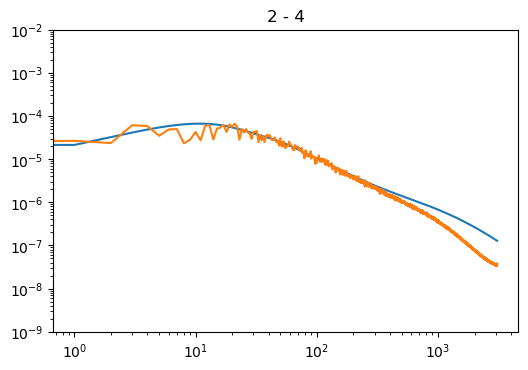

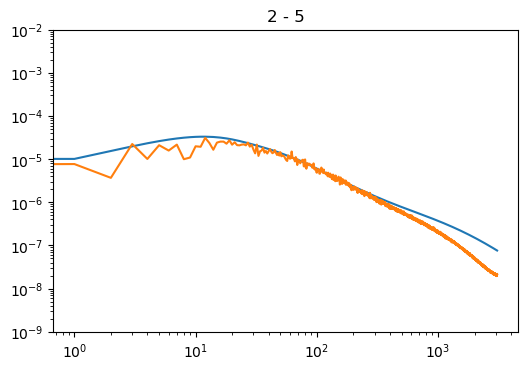

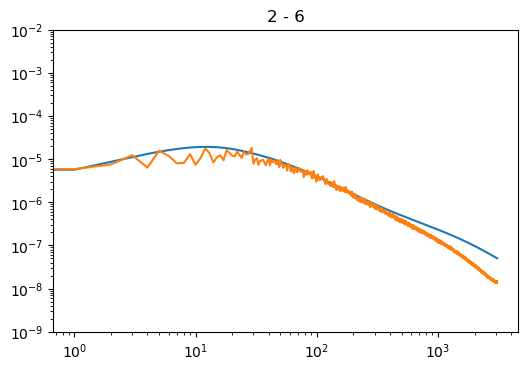

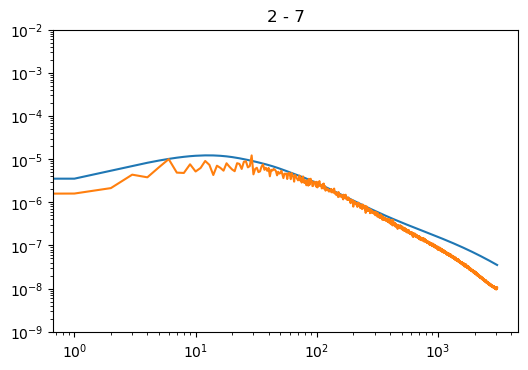

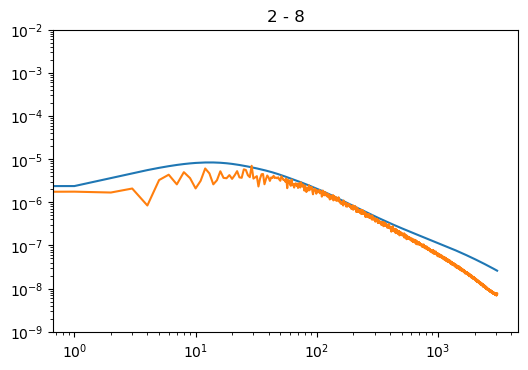

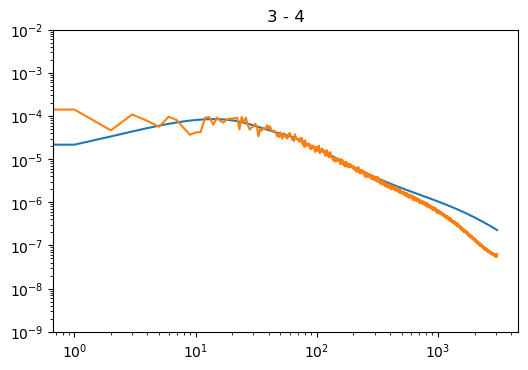

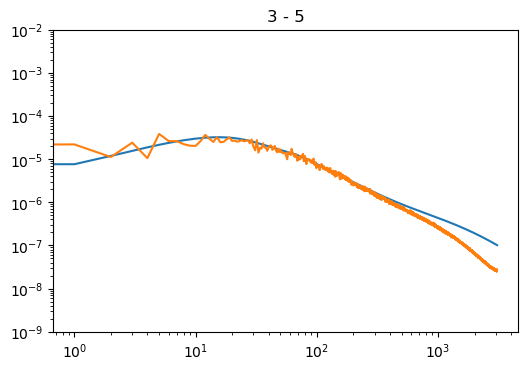

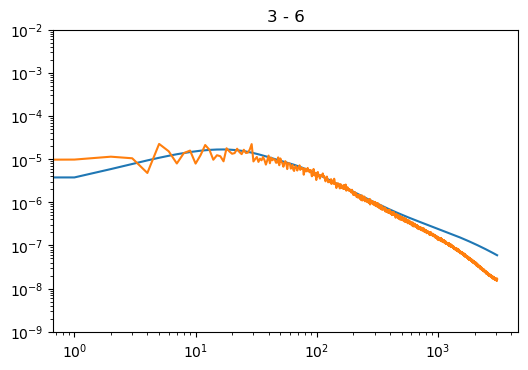

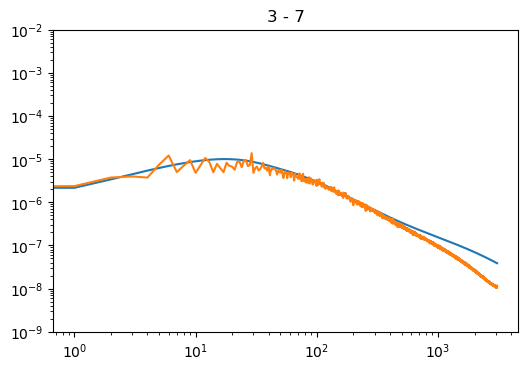

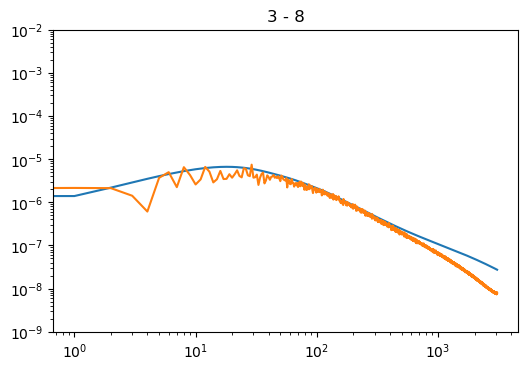

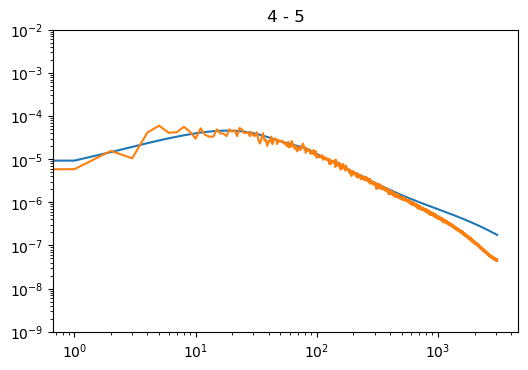

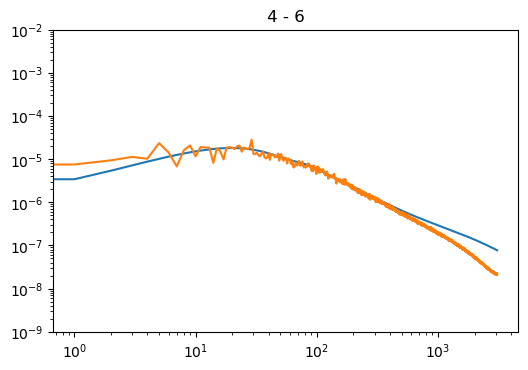

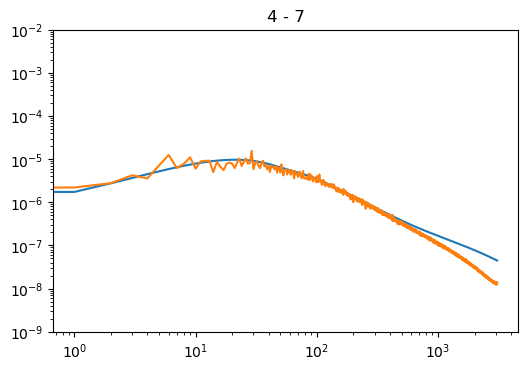

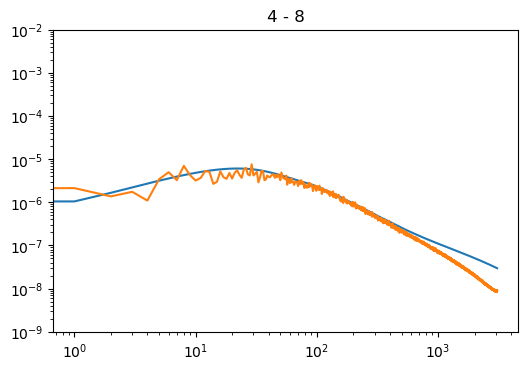

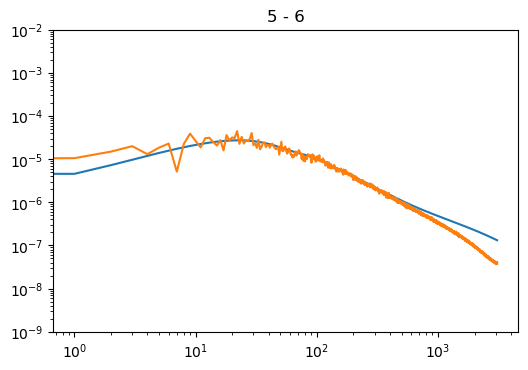

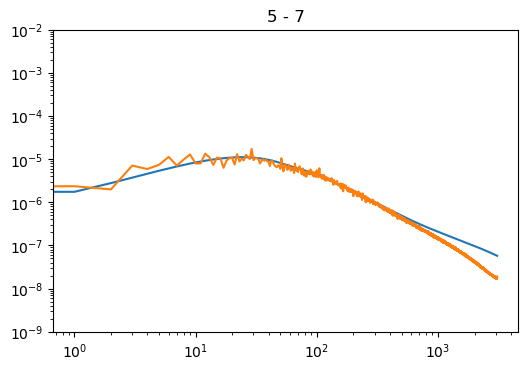

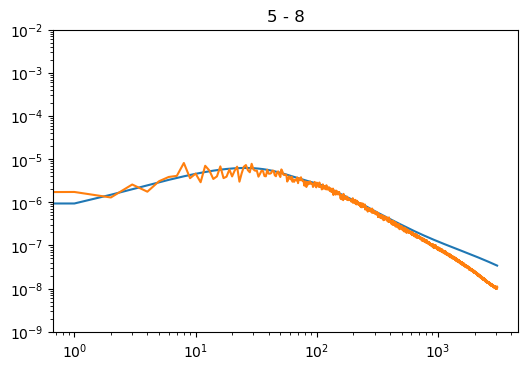

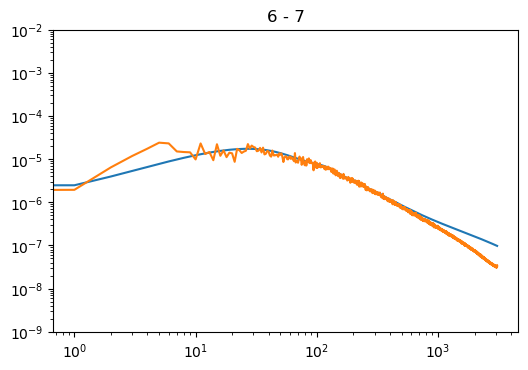

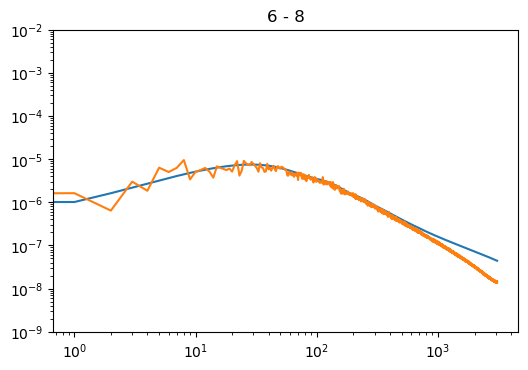

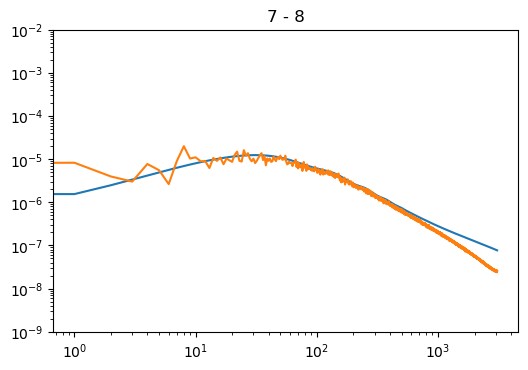

In [13]:
plt.figure(dpi=1200)
for start in range(0,numSections):
    for end in range(start+1, numSections+1):
        plt.figure(dpi=100)
        plt.loglog(cclOut[start,end])
        plt.loglog(simOut[start,end])
        plt.title(str(start)+" - "+str(end))
        plt.ylim(10**-9,10**-2);

In [14]:
# plt.figure(dpi=1200)
# for start in range(0,numSections):
#     for end in range(start+1, numSections+1):
#         plt.figure(dpi=100)
#         plt.loglog(cclOut[start,end]*ell*(ell+1))
#         plt.loglog(simOut[start,end]*ell*(ell+1))
#         plt.title(str(start)+" - "+str(end))
#         #plt.ylim(10**-9,10**-2);

## Convergence

In [15]:
convergence=np.load("MAPS/convergence_NS_1024_R_2968_P_2048_DV_80.npy")

In [23]:
cclOutK = np.zeros((numDivs,len(ell)))
simOutK = np.zeros((numDivs,len(ell)))

In [24]:
for i in range(5,numDivs):
    dNdz = np.zeros(z2048.shape)
    dNdz[0:i]=1
    
    lens2048 = ccl.WeakLensingTracer(cosmo, dndz=(z2048, dNdz)) #CCL automatically normalizes dNdz
    cclOutK[i] = ccl.angular_cl(cosmo, lens2048, lens2048,ell)
    
    simOutK[i] = hp.sphtfunc.anafast(convergence[i])

In [30]:
SSEK = np.sum(np.power(cclOutK[5:,:]-simOutK[5:,:],2),axis=1)

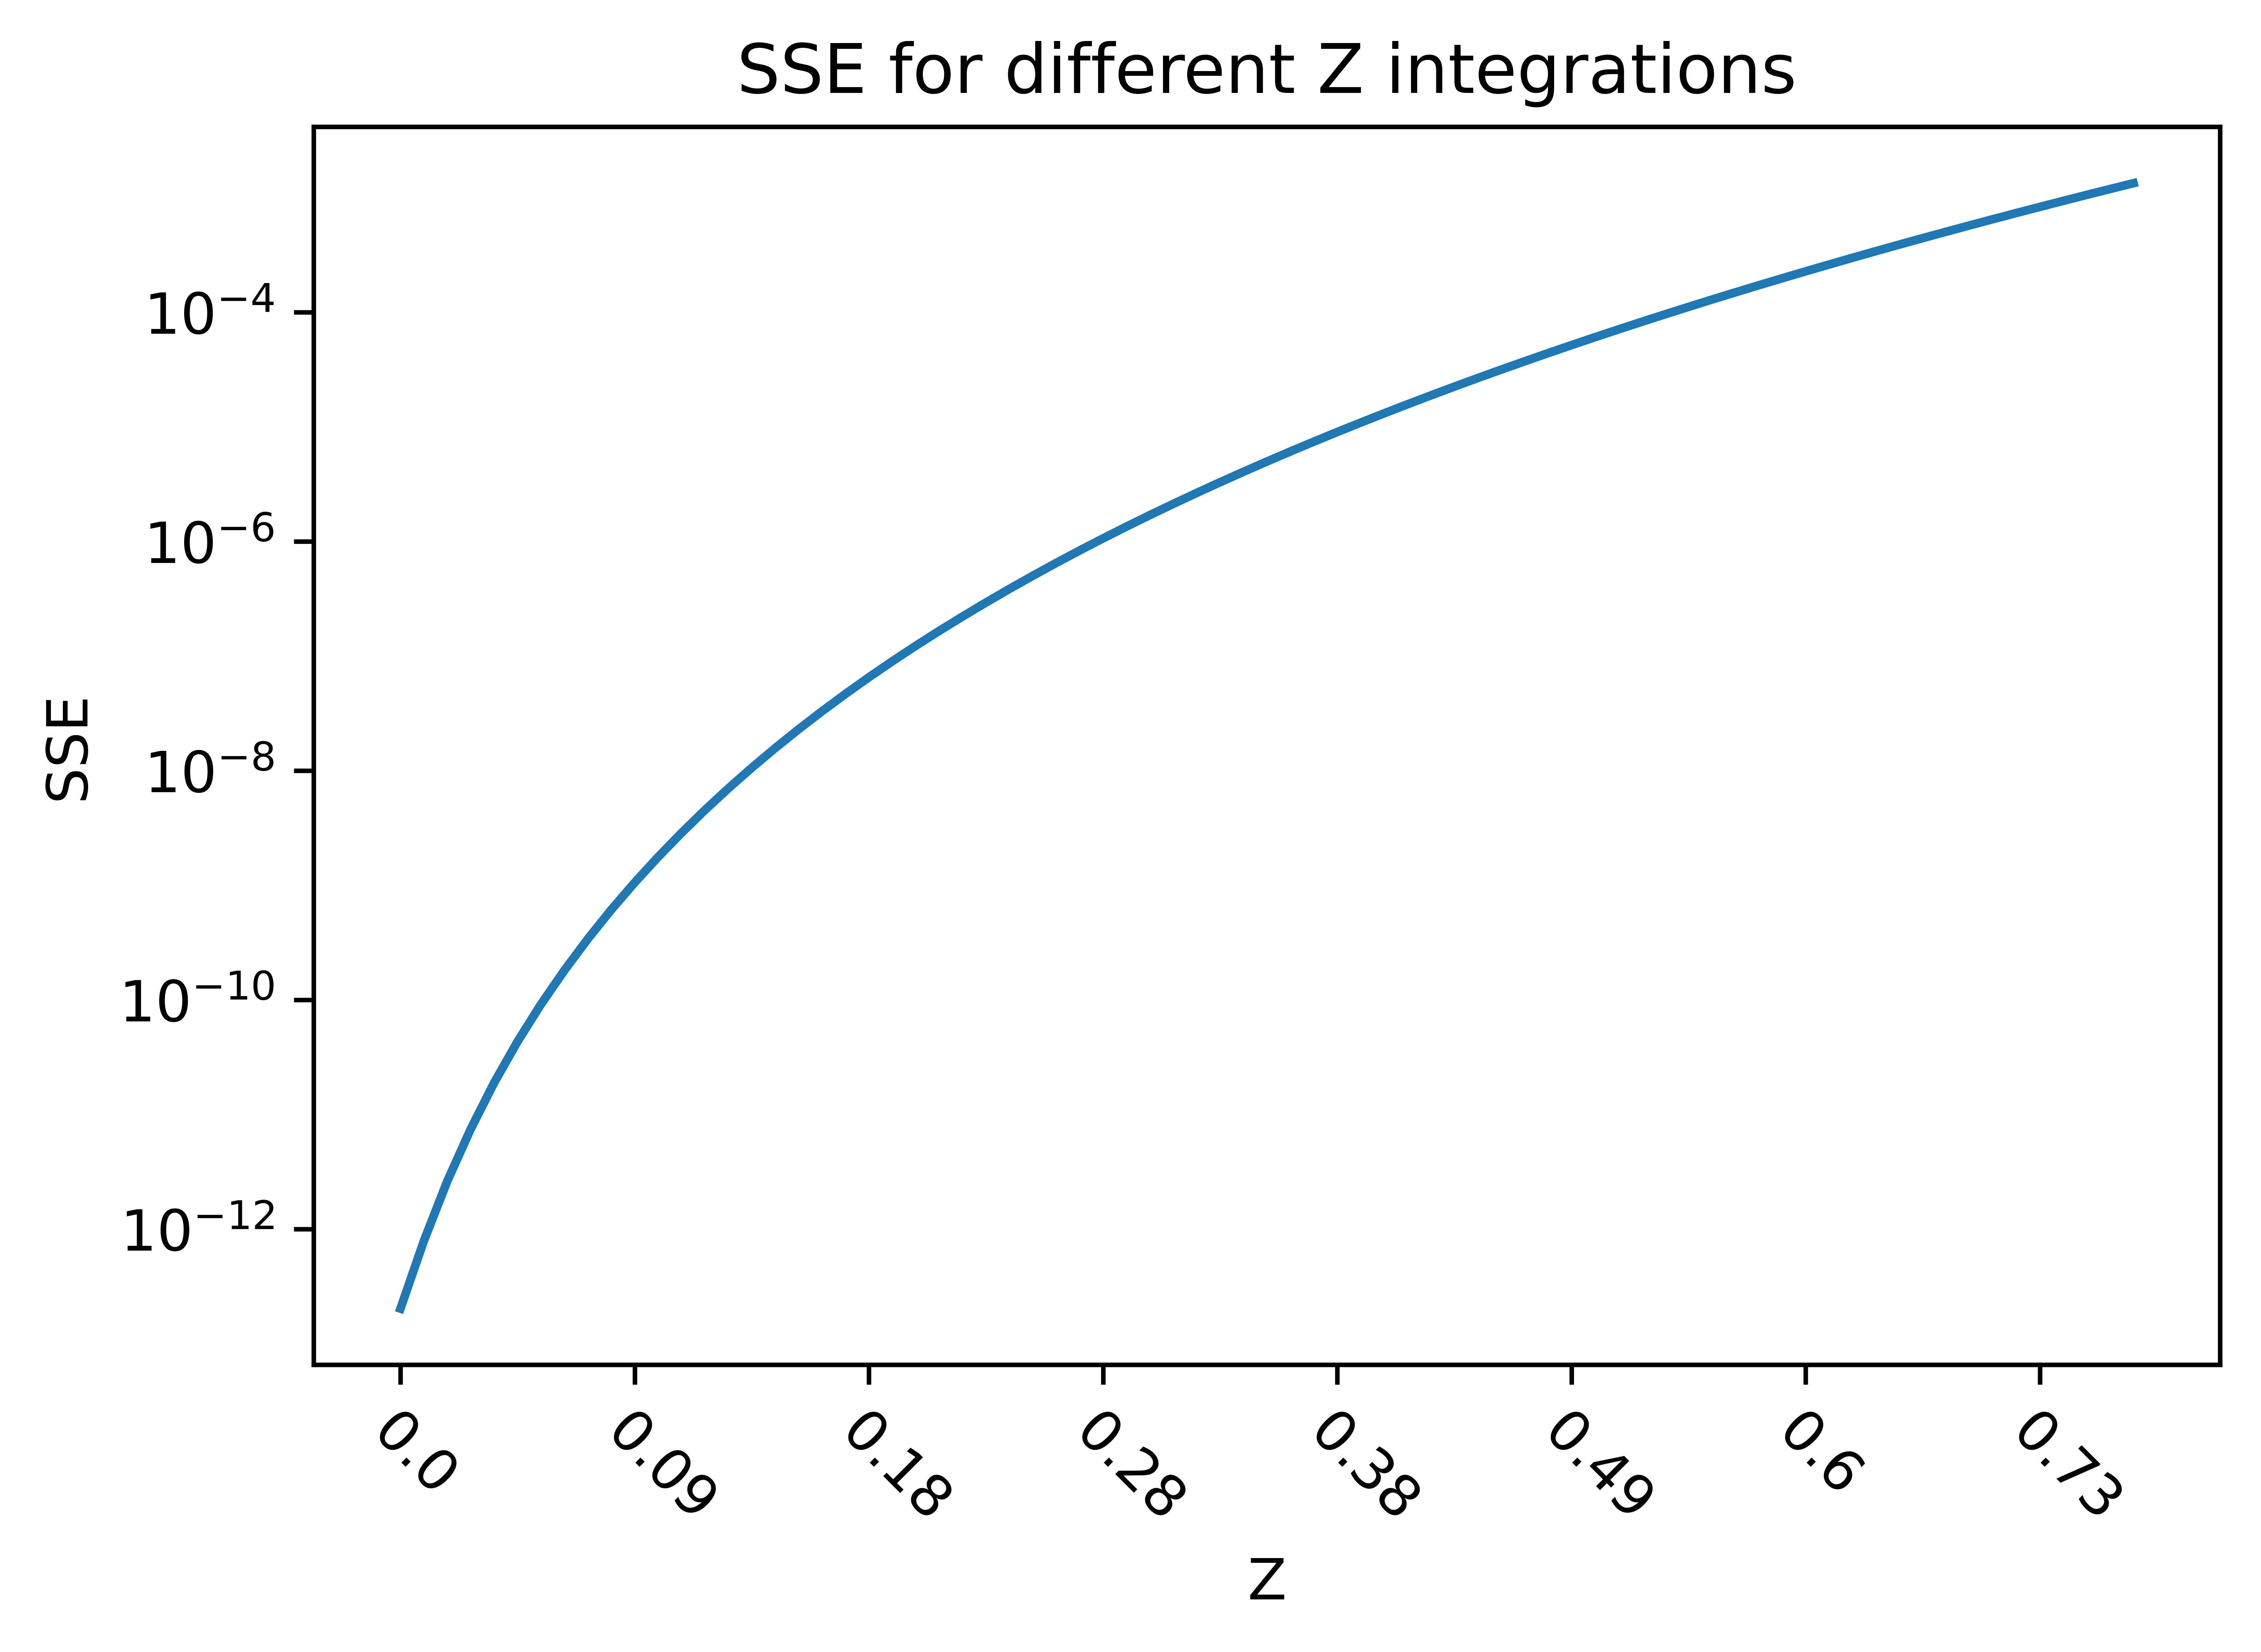

In [56]:
fig, ax = plt.subplots(dpi=1200)

im = ax.semilogy(SSEK);

labels = z2048[::10]

ax.set_xticks(np.arange(len(labels))*10)
ax.set_xticklabels(np.around(labels,2))

plt.setp(ax.get_xticklabels(), rotation=-45, ha="left",
         rotation_mode="anchor")

plt.xlabel("Z")
plt.ylabel("SSE")
ax.set_title("SSE for different Z integrations")

plt.show();

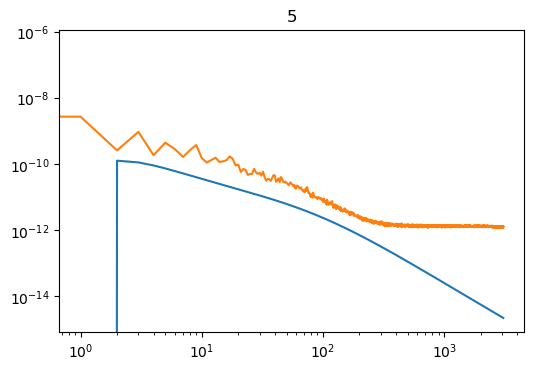

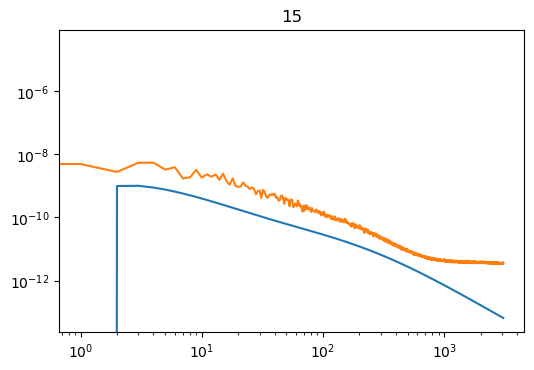

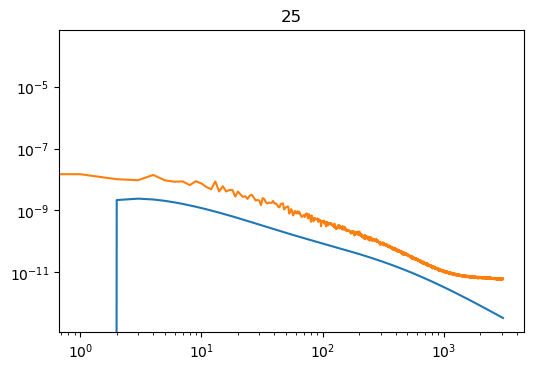

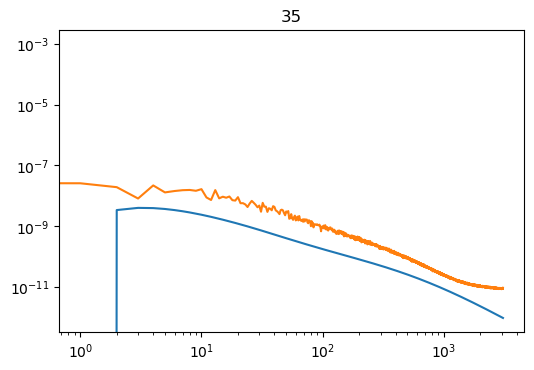

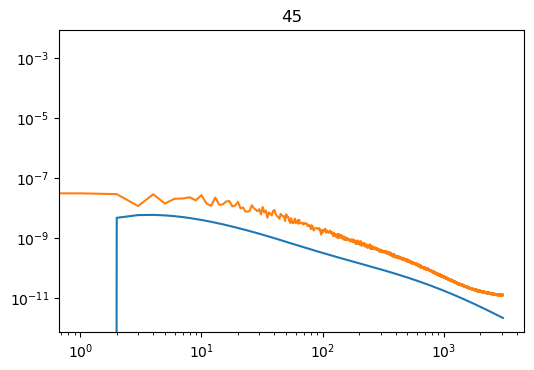

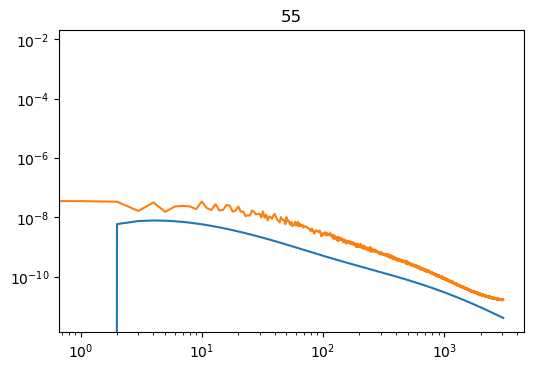

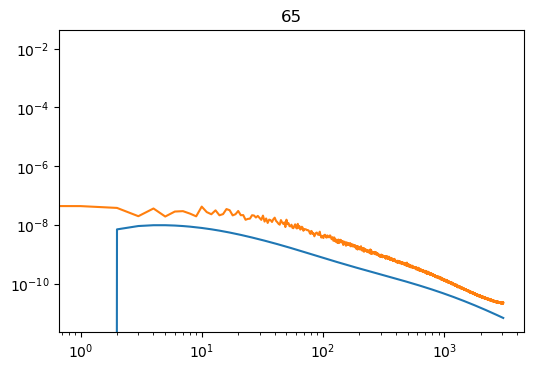

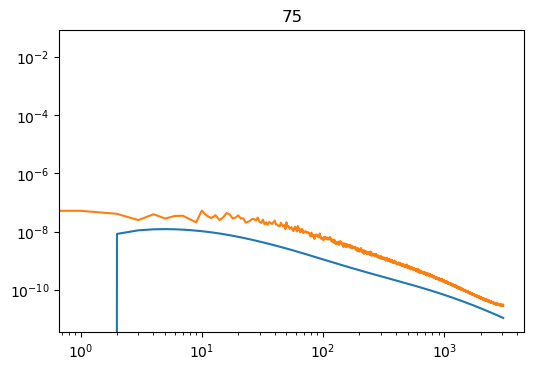

In [58]:
for i in range(5,numDivs,10):
    plt.figure(dpi=100)
    plt.loglog(cclOutK[i])
    plt.loglog(simOutK[i])
    plt.title(str(i))
    #plt.ylim(10**-9,10**-2);